# Model Testing on Test Dataset

A sample of the "Flight_Test" data to be tested against the candidate model. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import sklearn as sk
import numpy as np
import seaborn as sns
import statsmodels.api as sm

# Data Import

In [2]:
flight_df = pd.read_csv('flight_test_100k.csv')

# Data Cleaning and Transformation

In [3]:
flight_df = flight_df.drop(['branded_code_share', 'mkt_carrier','op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'dup', 'flights', 'dest_city_name', 'origin_city_name'], axis =1)


In [4]:
flight_df['crs_dep_time'] = flight_df['crs_dep_time'].round(-2)/100
flight_df['crs_arr_time'] = flight_df['crs_arr_time'].round(-2)/100

# format date
flight_df['fl_date'] = pd.DatetimeIndex(flight_df['fl_date']).date
# add year column
flight_df['fl_year'] = pd.DatetimeIndex(flight_df['fl_date']).year
# add month column
flight_df['fl_month'] = pd.DatetimeIndex(flight_df['fl_date']).month
# add day column
flight_df['fl_day'] = pd.DatetimeIndex(flight_df['fl_date']).day

In [5]:
# dummies for carrier
carrier_dummies = pd.get_dummies(flight_df['mkt_unique_carrier'])
flight_df = pd.concat([flight_df, carrier_dummies], axis=1)

In [6]:
# create route id in flight_df
flight_df[['origin_airport_id', 'dest_airport_id', 'fl_month']] =  flight_df[['origin_airport_id', 'dest_airport_id', 'fl_month']].astype(str)
flight_df['route_id'] = flight_df['origin_airport_id'] + flight_df['dest_airport_id']

In [7]:
# pass in passenger stats
pass_route_feats = pd.read_csv('pass_route_features.csv')
pass_route_feats['route_id'] = pass_route_feats['route_id'].astype(str)
flight_df = flight_df.merge(pass_route_feats, on='route_id', how='left')

In [8]:
# create carrier route id
flight_df['carrier_route_id'] = flight_df['origin_airport_id'] + flight_df['dest_airport_id'] + flight_df['mkt_unique_carrier']

In [9]:
carrier_route_delay_feats = pd.read_csv('carrier_route_delay_feats.csv')

In [10]:
flight_df = flight_df.merge(carrier_route_delay_feats, on='carrier_route_id', how='left')
flight_df = flight_df.rename(columns={'arr_delay_x': 'std_carrier_route_delay', 'arr_delay_y': 'avg_carrier_route_delay'})

In [11]:
dep_delay_airp_month = pd.read_csv('dep_delay_airp_month.csv')

In [12]:
dep_delay_airp_month['origin_air_month'] = dep_delay_airp_month['origin_air_month'].astype(str)

In [13]:
flight_df['origin_air_month'] = flight_df['origin_airport_id'] + flight_df['fl_month']
flight_df = flight_df.merge(dep_delay_airp_month, on='origin_air_month', how='left')

In [14]:
flight_df = flight_df.rename(columns={'dep_delay_x': 'std_dep_delay_airp_month', 'dep_delay_y': 'avg_dep_delay_airp_month'})

In [15]:
flight_df['route_id'] =  flight_df['route_id'].astype(float)
flight_df['fl_month'] =  flight_df['fl_month'].astype(float)
flight_df = flight_df.dropna()

In [16]:
from sklearn.preprocessing import StandardScaler
flight_df_std_trans = flight_df
cols = ['std_carrier_route_delay', 'avg_carrier_route_delay', 'std_dep_delay_airp_month', 'avg_dep_delay_airp_month', 'origin_airport_id', 'dest_airport_id', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'fl_year', 'fl_month', 'fl_day', 'mail_ratio', 'capacity_ratio', 'freight_ratio', 'mail_per_flight', 'freight_per_flight', 'pass_per_flight']
cols_scaled = ['std_carrier_route_delay', 'avg_carrier_route_delay', 'std_dep_delay_airp_month', 'avg_dep_delay_airp_month', 'origin_airport_id', 'dest_airport_id', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'fl_year', 'fl_month', 'fl_day', 'mail_ratio', 'capacity_ratio', 'freight_ratio', 'mail_per_flight', 'freight_per_flight', 'pass_per_flight']
scaler = StandardScaler()
flight_df_std_trans[cols_scaled] = scaler.fit_transform(flight_df_std_trans[cols])

In [17]:
model_submission = flight_df_std_trans[['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', 'dest']]
flight_df_std_trans = flight_df_std_trans.drop(['origin', 'dest', 'mkt_carrier_fl_num', 'route_id', 'origin_airport_id', 'dest_airport_id', 'carrier_route_id', 'origin_air_month', 'fl_date', 'mkt_unique_carrier', 'origin_air_month'], axis =1)

# Import Model

In [18]:
import pickle
loaded_model = pickle.load(open('finalized_lin_reg_model.sav', 'rb'))

In [19]:
X = flight_df_std_trans
X = sm.add_constant(X)

# Results

In [20]:
result = loaded_model.predict(X)

In [21]:
model_submission = pd.concat([model_submission, result], axis=1)
model_submission = model_submission.rename(columns={0: 'predicted_delay', 'mkt_unique_carrier': 'mkt_carrier'})

In [22]:
model_submission.reset_index(inplace=True)
model_submission = model_submission.drop(['index'], axis=1)
model_submission

,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predicted_delay
0,2020-01-22,AS,1768,PDX,LAX,4.340817
1,2020-01-15,DL,5377,JFK,DFW,4.414690
2,2020-01-09,AA,3534,CMH,ORD,4.525790
3,2020-01-15,AA,2148,DCA,BOS,4.390692
4,2020-01-04,B6,914,FLL,HPN,4.555356
...,...,...,...,...,...,...
70734,2020-01-15,DL,1729,LAX,LAS,4.439754
70735,2020-01-29,WN,5769,PHX,SLC,4.569683
70736,2020-01-21,UA,1982,DEN,SAN,4.530844
70737,2020-01-17,DL,2923,DTW,CLT,4.442441


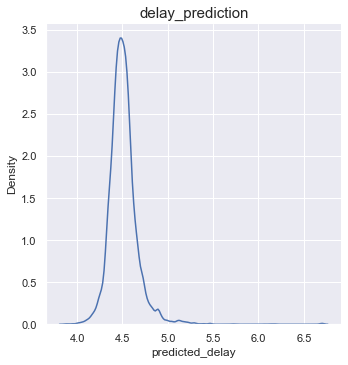

In [23]:
sns.set_theme(style="darkgrid")
sns.displot(model_submission, x='predicted_delay',kind='kde')
plt.title("delay_prediction", size=15)
plt.show()

# Export

In [24]:
from pathlib import Path 
filepath = Path('./flight_delay_pred_model_submission.csv')  
model_submission.to_csv(filepath)